### Dataset: 
#### PM2.5 Data of Five Chinese Cities Data Set 
[Link to dataset](https://archive.ics.uci.edu/ml/datasets/PM2.5+Data+of+Five+Chinese+Cities)

#### Data Set Information:

The time period is between Jan 1st, 2010 to Dec 31st, 2015. Missing data are denoted as NA. 



#### Attribute Information:

**No**: row number 

**year**: year of data in this row 

**month**: month of data in this row 

**day**: day of data in this row 

**hour**: hour of data in this row 

**season**: season of data in this row 

**PM**: PM2.5 concentration (ug/m^3)  **OUTPUT**

**DEWP**: Dew Point (Celsius Degree) 

**TEMP**: Temperature (Celsius Degree)

**HUMI**: Humidity (%) 

**PRES**: Pressure (hPa) 

**cbwd**: Combined wind direction 

**Iws**: Cumulated wind speed (m/s) 

**precipitation**: hourly precipitation (mm)

**Iprec**: Cumulated precipitation (mm)


In [1]:
# import base packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# to enable multiple command output on the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Missing data visualization module for Python.
# install using "conda install -c conda-forge missingno"
# or pip install missingno
import missingno as msno

In [219]:
# utility functions

# compute correlation
def compute_corr(df, list_var, method='pearson'):
        
    return df[list_var].corr(method=method)

# compute rolling aggragation
def rolling_agg(df, str_var, horizon='D', agg_func= np.mean ):
        
    return df[str_var].rolling(horizon).agg(agg_func)


# format as Markdown in printing
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

# compute and return correlation matrix while drawing chart
def draw_corr_matrix(var_list, df, fig_size=(11, 9)):

    corr=df.loc[:,var_list].dropna().corr()   

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize= fig_size)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    _= sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
    return corr

def resample_and_shift(df, str_var, str_new_var, agg_func= np.mean, horizon="D", shift_amount=-1):
    ''' Add a new column to input dataframe by
        resampling using the specified agg_func and
        horizon, eventually shift it back (shift_amount<0)
        or forward '''

    #compute daily means of selected variable
    resampled_agg_var = df[str_var].resample(horizon).agg(agg_func)
    
    # Add column to raw data (NaN introduced)
    df[str_new_var]=resampled_agg_var 

    # fill NaN
    df[str_new_var].fillna(method="ffill", inplace=True)
 
    if shift_amount != 0:
        # shift data (1 day before = -1)
        df[str_new_var]=df[str_new_var].shift(shift_amount, freq = horizon)

In [4]:
sns.__version__

'0.9.0'

## Read raw data

- Hourly sampled data

In [5]:
# Define base path  of folder containing .csv raw files
base_path= './data' #'/Users/GUE/Downloads/materiale_lstm/FiveCitiePMData'

# define columns to read/keep
columns_to_keep=[ 'year', 'month', 'day', 'hour', 'season',  'PM_US Post', 'DEWP', 'HUMI',
       'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation', 'Iprec']

In [6]:
Beijing=pd.read_csv(base_path+'/BeijingPM20100101_20151231.csv',usecols=columns_to_keep, na_values=['NA'], 
                    low_memory=False)

# add new column Dates as datetime
Beijing["Dates"]= pd.to_datetime(Beijing.iloc[:,0:4])

# add month name
Beijing["month_name"]=Beijing["Dates"].dt.month_name()

# add day name
Beijing["day_name"]=Beijing["Dates"].dt.day_name()

Beijing.rename({"PM_US Post":"PM"}, inplace=True, axis=1)

# set datetime index for easy time series manipulation
Beijing.set_index("Dates", inplace=True)

# show extract from raw data for date 2010-Jan-03
Beijing.loc['2010-01-03'].head()

#Show data types
df_types= pd.DataFrame(Beijing.dtypes, columns=['dataType'])
df_types.rename_axis("Variable")
#Beijing.info()

,year,month,day,hour,season,PM,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,month_name,day_name
Dates,,,,,,,,,,,,,,,,
2010-01-03 00:00:00,2010,1,3,0,4,63.0,-7.0,92.0,1027.0,-6.0,SE,58.56,0.4,0.4,January,Sunday
2010-01-03 01:00:00,2010,1,3,1,4,65.0,-8.0,85.0,1026.0,-6.0,SE,61.69,0.5,0.9,January,Sunday
2010-01-03 02:00:00,2010,1,3,2,4,55.0,-8.0,92.0,1026.0,-7.0,SE,65.71,0.5,1.4,January,Sunday
2010-01-03 03:00:00,2010,1,3,3,4,65.0,-8.0,92.0,1025.0,-7.0,SE,68.84,0.7,2.1,January,Sunday
2010-01-03 04:00:00,2010,1,3,4,4,83.0,-8.0,92.0,1024.0,-7.0,SE,72.86,1.2,3.3,January,Sunday


,dataType
Variable,
year,int64
month,int64
day,int64
hour,int64
season,int64
PM,float64
DEWP,float64
HUMI,float64
PRES,float64


### Verify percentage NaN data for each feature

In [7]:
pd.DataFrame((Beijing.isnull().sum()/Beijing.shape[0])*100, columns=["percentage null %"]).rename_axis('Variable')

,percentage null %
Variable,
year,0.000000
month,0.000000
day,0.000000
hour,0.000000
season,0.000000
PM,4.178077
DEWP,0.009509
HUMI,0.644683
PRES,0.644683


[datetime in pandas](https://medium.com/jbennetcodes/dealing-with-datetimes-like-a-pro-in-pandas-b80d3d808a7f)

In [9]:
# datetimeIndex containing null PM values
df_index_null_PM=Beijing[Beijing['PM'].isnull()].index

df_dates_null_PM=pd.DataFrame(data=df_index_null_PM)
#type(df_dates_null_PM.index)

df_dates_null_PM["Num_null"]=1
#df_dates_null_PM.head()

number_dates_with_null_PM=df_dates_null_PM['Dates'].map(lambda t: t.date()).unique().shape[0]

number_unique_dates=Beijing.index.map(lambda t: t.date()).unique().shape[0]

percentage_dates_null_PM= np.floor((number_dates_with_null_PM/number_unique_dates)*100)

printmd("#### Number of days containing null PM 2.5 values: {} (on {} equal to {}%)".format(number_dates_with_null_PM,\
                                                                number_unique_dates, percentage_dates_null_PM))

#### Number of days containing null PM 2.5 values: 282 (on 2191 equal to 12.0%)

In [10]:
# retrive dates containing null PM 2.5 values
dates_null_PM=df_dates_null_PM.groupby(df_dates_null_PM['Dates'].dt.date).agg({'Num_null': lambda x: x.sum()}).sort_values(by='Num_null', ascending=False)

dates_null_PM.set_index(pd.to_datetime(dates_null_PM.index), inplace=True)
#type(dates_null_PM.index)

# Count num dates with null PM for each year
dates_null_PM.groupby([dates_null_PM.index.year]).count()

dates_null_PM["month"]= dates_null_PM.index.month_name()
dates_null_PM["year"]= dates_null_PM.index.year
dates_null_PM.reset_index(level=0, inplace=True)

# gather columns
df_null_PM= pd.melt(dates_null_PM, id_vars=['month','year'], value_vars=['Num_null'], value_name='Num_days_null_PM')

,Num_null
Dates,
2010,46
2011,71
2012,65
2013,35
2014,32
2015,33


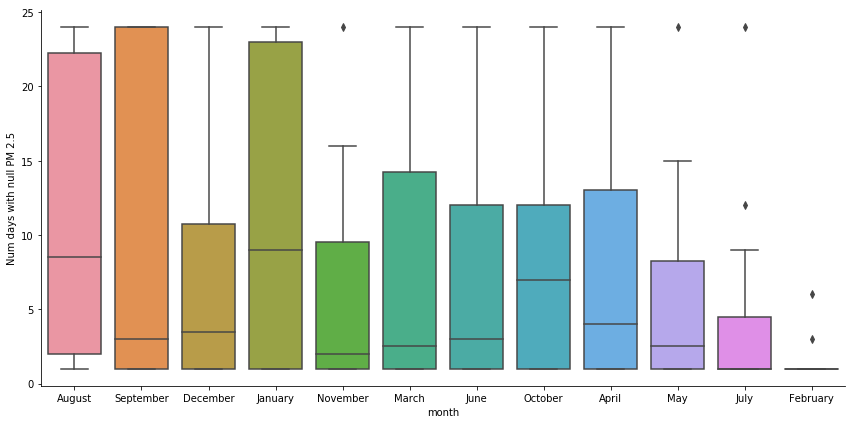

In [11]:
# Boxplot by month of num days with null PM 2.5 (all years)
_= sns.catplot(x="month", y="Num_days_null_PM", kind="box", 
            data=df_null_PM, aspect=2, height=6)
_= plt.ylabel("Num days with null PM 2.5")

#### Missing values analysis using module Missingno
[Missingno module](https://github.com/ResidentMario/missingno)

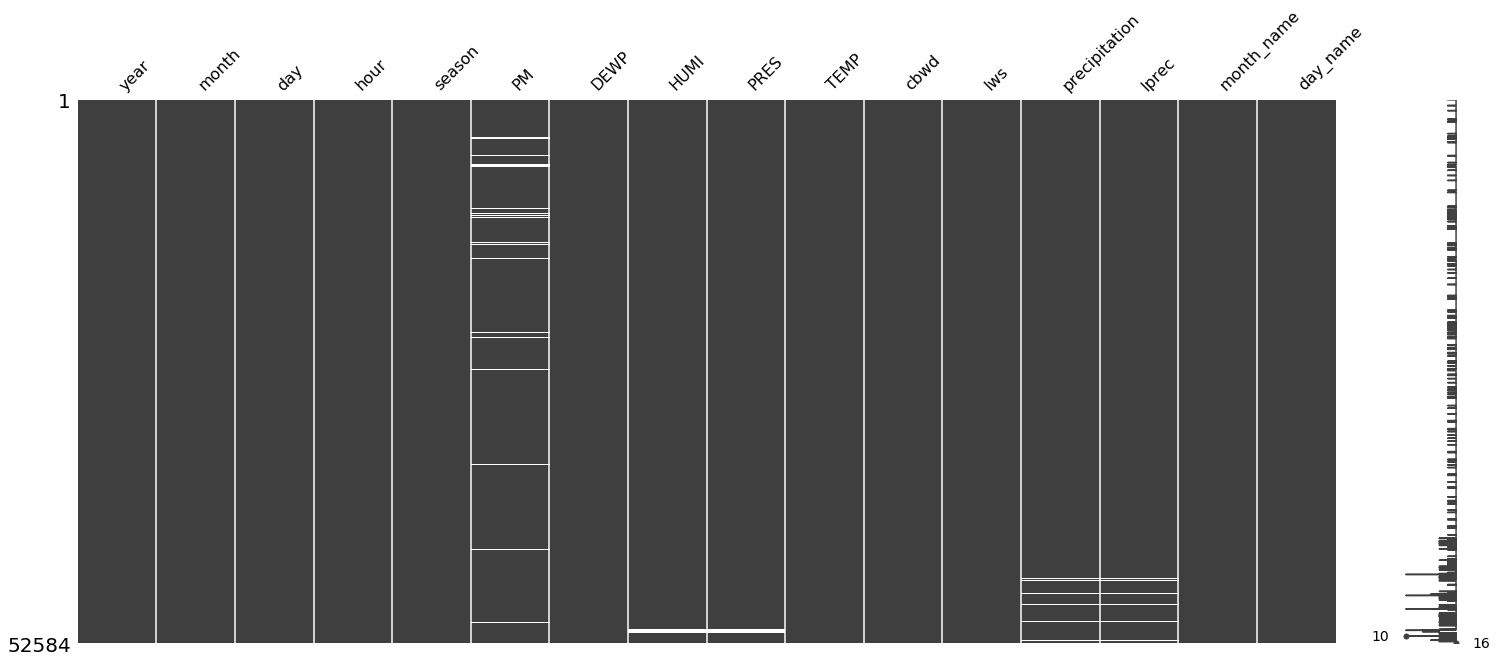

In [12]:
_= msno.matrix(Beijing)

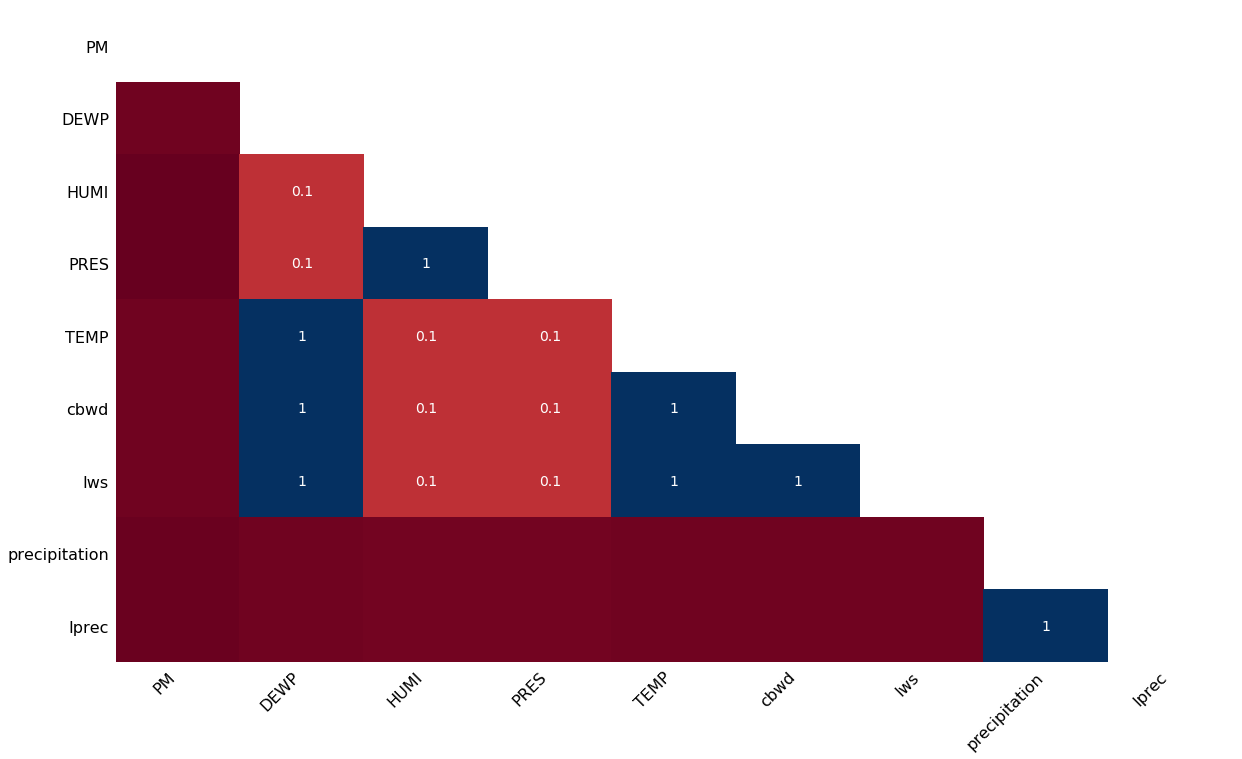

In [13]:
_= msno.heatmap(Beijing)

## Matrix correlation for all raw data
- Only HUMI show an appreciable correlation with PM

,PM,year,month,day,hour,season,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec
PM,1.000000,-0.055131,-0.012855,0.077908,0.000166,0.124108,0.133233,0.419491,-0.019871,-0.123285,-0.240018,-0.027093,-0.043672
year,-0.055131,1.000000,-0.018025,-0.000671,-0.000009,-0.005330,0.030392,-0.021913,-0.007185,0.060923,-0.063797,-0.010230,-0.018125
month,-0.012855,-0.018025,1.000000,0.012492,-0.000349,0.195820,0.255514,0.215302,-0.063405,0.173101,0.017730,0.016733,0.023558
day,0.077908,-0.000671,0.012492,1.000000,0.000345,-0.011161,0.040839,0.041997,-0.002632,0.020039,-0.016626,-0.001001,0.003448
hour,0.000166,-0.000009,-0.000349,0.000345,1.000000,0.000394,-0.020964,-0.256276,-0.041955,0.151230,0.059678,0.006381,-0.005966
season,0.124108,-0.005330,0.195820,-0.011161,0.000394,1.000000,-0.417331,0.029564,0.564618,-0.572560,0.036741,-0.023714,-0.021613
DEWP,0.133233,0.030392,0.255514,0.040839,-0.020964,-0.417331,1.000000,0.612170,-0.772658,0.821416,-0.286537,0.083202,0.086627
HUMI,0.419491,-0.021913,0.215302,0.041997,-0.256276,0.029564,0.612170,1.000000,-0.234500,0.077836,-0.306823,0.097002,0.120889
PRES,-0.019871,-0.007185,-0.063405,-0.002632,-0.041955,0.564618,-0.772658,-0.234500,1.000000,-0.825144,0.168600,-0.064131,-0.072790
TEMP,-0.123285,0.060923,0.173101,0.020039,0.151230,-0.572560,0.821416,0.077836,-0.825144,1.000000,-0.140524,0.045718,0.038141


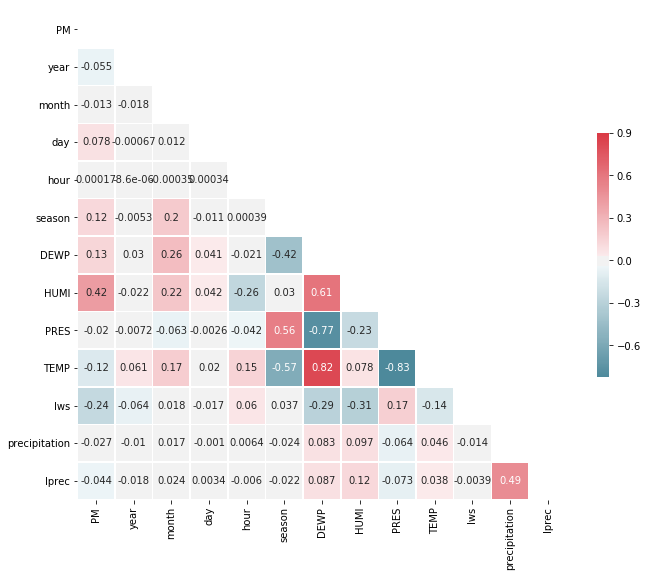

In [15]:
all_var= Beijing.columns.tolist()
# bring "PM" at first place
all_var.insert(0, all_var.pop(all_var.index("PM"))) 
draw_corr_matrix(df=Beijing, var_list=all_var)

### ACF "PM"

PM  2.5 concentration show higly autocorrelation values

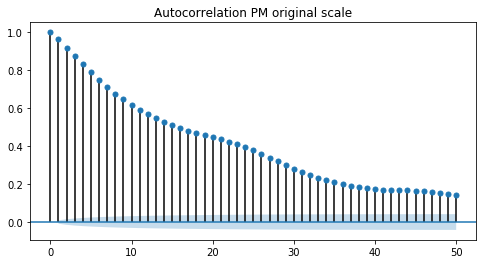

In [16]:
_ ,ax = plt.subplots(figsize=[8,4])
_=plot_acf(Beijing["PM"].dropna().values, lags=50, title="Autocorrelation PM original scale", ax=ax)

### Density plots for PM 2.5 by year

Density plots for PM 2.5 concentration show similar results for different years available

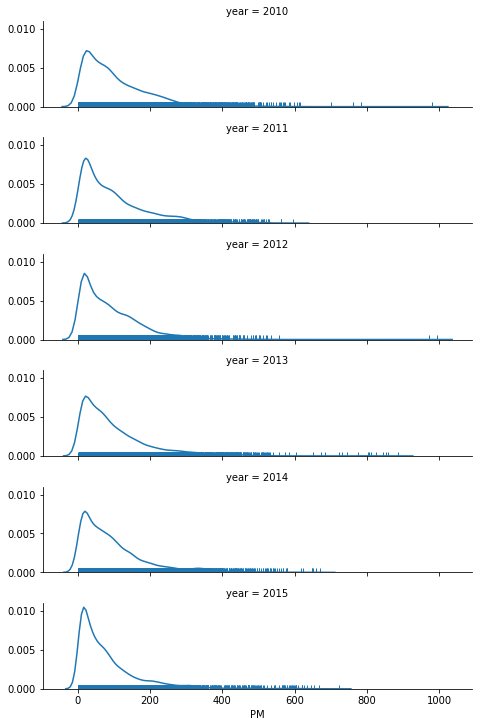

In [17]:
# to suppress FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


g = sns.FacetGrid(Beijing, row="year", dropna=True, legend_out=True,
                  height=1.7, aspect=4,);
_= g.map(sns.distplot, "PM", hist=False, rug=True);

### Statistics for PM grouped by year

Only Max(PM) for year 2011 is noticeable lower if compared to others years

In [18]:
Beijing.groupby("year")["PM"].describe(percentiles= [.25, .5, .75,.95])

,count,mean,std,min,25%,50%,75%,95%,max
year,,,,,,,,,
2010,8091.0,104.045730,92.281185,1.0,35.0,79.0,147.0,274.00,980.0
2011,8033.0,99.093240,92.982231,2.0,27.0,71.0,139.0,288.00,595.0
2012,8293.0,90.538768,81.720025,1.0,25.0,69.0,132.0,252.00,994.0
2013,8678.0,101.711109,98.071410,2.0,32.0,71.5,138.0,306.15,886.0
2014,8661.0,97.734095,93.531902,2.0,28.0,72.0,133.0,308.00,671.0
2015,8631.0,82.784729,88.492918,1.0,22.0,55.0,109.0,261.00,722.0


### Transform PM into log10 scale

PM distribution is right skewed, could be beneficial to transform it using log10

In [19]:
Beijing['PMlog']= np.log10(Beijing['PM'])

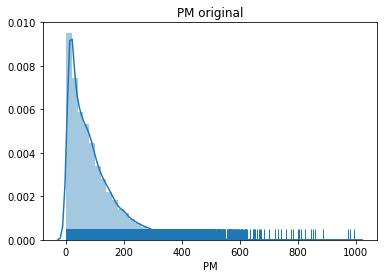

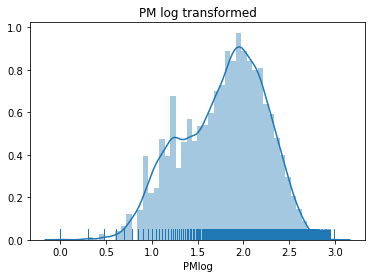

In [20]:
_=sns.distplot(Beijing["PM"].dropna(), kde=True, rug=True)
_=plt.title("PM original");
plt.show()

_=sns.distplot(Beijing["PMlog"].dropna(), kde=True, rug=True);
_=plt.title("PM log transformed");
plt.show()

Read  following paper to have and idea of atmosferic variables on PM 2.5 concentration

[Effects of Meteorological Conditions on PM2.5 Concentrations in Nagasaki, Japan](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4555266/)

# Iprec & precipitation

"Iprec" culumated precipitation in [mm]

"precipitation" hourly precipitation (mm)

- show similar distributions, 
- are extremely high skewed with outliers (NEED to be fixed)
- Outliers (removed with mask >300)
- **replaced with 2D rolling window of max values, this improves correlation (Pearson)
  with PM (from -0.043721 to -0.136013)** 	

In [21]:
Beijing[["Iprec","precipitation"]].describe()

,Iprec,precipitation
count,52100.000000,52100.000000
mean,19.519008,19.258683
std,4381.036040,4381.035532
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,999990.000000,999990.000000


- remove outliers (values >300)

In [22]:
Beijing.loc[Beijing['Iprec'] >300 ,'Iprec'] = np.nan
Beijing.loc[Beijing['precipitation'] >300 ,'precipitation'] = np.nan
Beijing[["Iprec","precipitation"]].describe()

,Iprec,precipitation
count,52099.000000,52099.000000
mean,0.325348,0.065019
std,3.896166,0.858786
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,223.000000,69.200000


- Removing "precipitation" having low variace!!

In [23]:
Beijing.drop(["precipitation"], inplace=True, axis=1)

 - Violinplot for "Iprec" shows that most values are clustered around zero
 - Month most rainy are: July, August,  and November

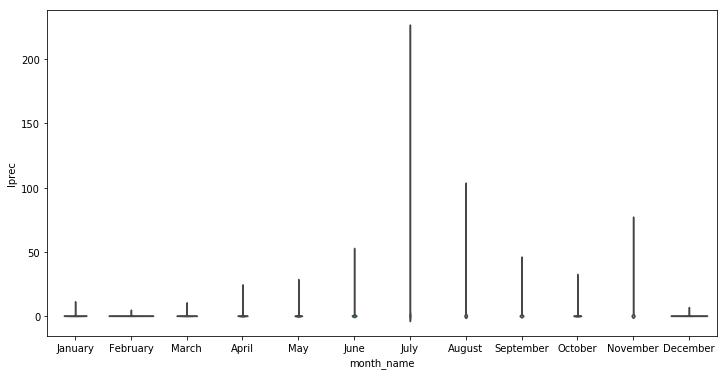

In [44]:
# Violinplots for "Iprec"
_,ax=plt.subplots(figsize=(12,6))
_=sns.violinplot(x="month_name", y="Iprec", data=Beijing, ax=ax, inner=None)

Spearman correlation between PM2.5 and Iprec is negative 

in accordance to paper's results (see link above)

but is very low, from -0.00025 (year 2013) to -0.077 (year 2015), 

in paper was in range −0.0606 to −0.197.

In [143]:
# g = sns.lmplot(x="Iprec", y="PMlog",  col="year", data=Beijing,
#                 y_jitter=.02)

In [49]:
# used PM and not PMlog for comparison with paper's results
compute_corr(Beijing.groupby("year"), list_var=["PM","Iprec"], method="spearman") \
['Iprec'].loc[:,'PM'].to_frame('corr PM - Iprec (Spearman)')
# considering PMlog and Pearson correlation, results slightly improve (not shown)

,corr PM - Iprec (Spearman)
year,
2010,-0.031469
2011,-0.035858
2012,0.006875
2013,-0.002549
2014,-0.026349
2015,-0.077257


### TEST RESAMPLING AND SHIFTING BACK

In [135]:
Iprec_daily_median_1D= Beijing["Iprec"].resample('D').mean()#compute daily means of selected variable
Beijing["Iprec_daily_median_1D"]=Iprec_daily_median_1D # Add column to raw data (NaN introduced)

#Beijing["2010-01-03"][['Iprec_daily_median_1D','PM']].head()
Beijing["Iprec_daily_median_1D"].fillna(method="ffill", inplace=True) # fill NaN
#Beijing["2010-01-02":"2010-01-03"][['Iprec_daily_median_1D','PM']]

Beijing["Iprec_daily_median_1D_shift_1D"]=Beijing["Iprec_daily_median_1D"].shift(-1, freq='D') # shift data 1 day before

#Beijing["2010-01-02":"2010-01-03"][['Iprec_daily_median_1D','Iprec_daily_median_1D_shift_1D','PM']]

In [136]:
Beijing[['PM','Iprec_daily_median_1D_shift_1D','Iprec_daily_median_1D','Iprec']].corr()

,PM,Iprec_daily_median_1D_shift_1D,Iprec_daily_median_1D,Iprec
PM,1.000000,0.045003,-0.031627,-0.043721
Iprec_daily_median_1D_shift_1D,0.045003,1.000000,0.273291,0.153165
Iprec_daily_median_1D,-0.031627,0.273291,1.000000,0.560492
Iprec,-0.043721,0.153165,0.560492,1.000000


In [142]:
resample_and_shift(Beijing, "Iprec","Iprec_new",  agg_func=np.mean)
Beijing[['PM','Iprec_new','Iprec']].corr()

YES


,PM,Iprec_new,Iprec
PM,1.000000,0.045003,-0.043721
Iprec_new,0.045003,1.000000,0.153165
Iprec,-0.043721,0.153165,1.000000


Computing a **2D rolling max for Iprec** seems to improve correlation

,IprecRoll_max_2D,Iprec
PM,-0.136013,-0.043721
PMlog,-0.150915,-0.042893


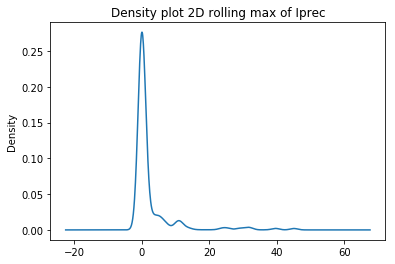

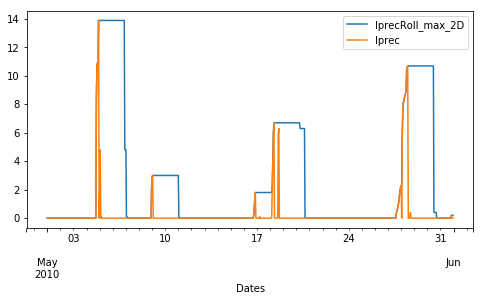

In [165]:
Beijing["IprecRoll_max_2D"]=Beijing["2010"]['Iprec'].rolling('2D').max()
Beijing[['PM','PMlog','IprecRoll_max_2D','Iprec']].corr().iloc[:2,2:]

# Density plot aggragated variable
_= Beijing["IprecRoll_max_2D"].plot(kind="kde", title="Density plot 2D rolling max of Iprec")

# Comparison between Iprec and aggregated 2D rolling max
_= Beijing["2010-05"][["IprecRoll_max_2D","Iprec"]].plot(figsize=(8,4))

## TEMP
temperature in <sup>o</sup>C

**"TEMP" is not highly correlated with PM as reported in paper (where R<sup>2</sup> in 0.3-0.9)**
- no aggragation method was able to improve significantly the correlation of TEMP with PM
- correlation between TEMP and PM vary in sign by month/year (**something wrong!**)

,count,mean,std,min,25%,50%,75%,max
TEMP,52579.0,12.58704,12.098527,-19.0,2.0,14.0,23.0,42.0


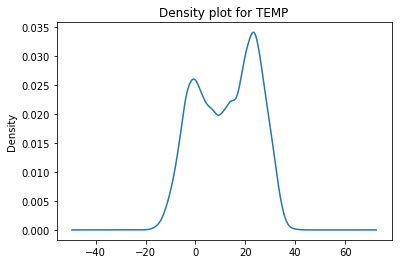

In [169]:
Beijing['TEMP'].describe().to_frame().T
_= Beijing['TEMP'].plot(kind="kde", title="Density plot for TEMP")

,corr PM - TEMP (Pearson)
year,
2010,0.162047
2011,0.123583
2012,0.001112
2013,-0.101400
2014,-0.119346
2015,-0.184257


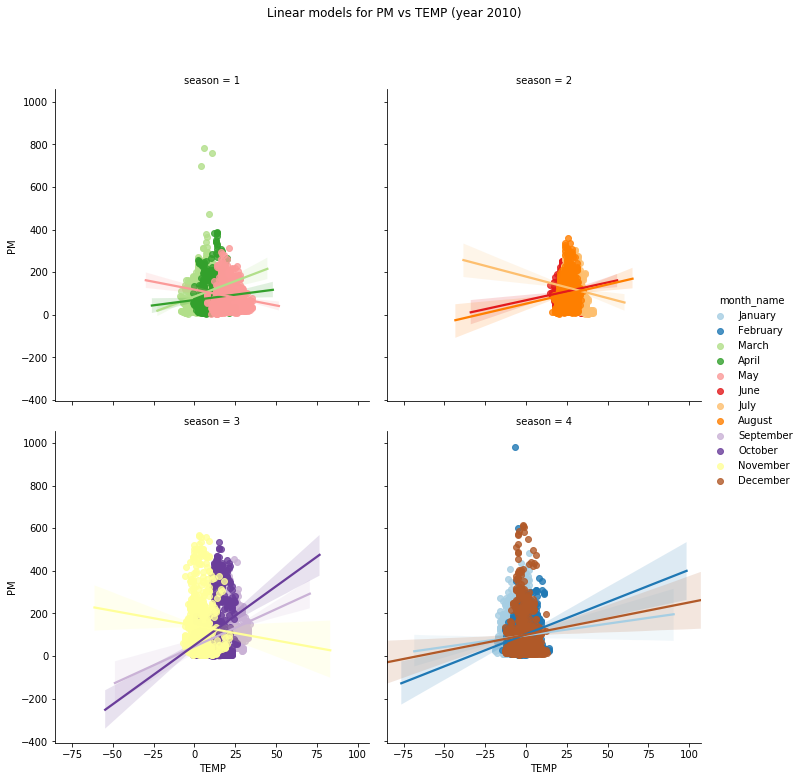

In [185]:
Beijing.groupby(['year'])[['PM','PMlog','TEMP']].corr(method="spearman")['TEMP'].loc[:,'PM']. \
to_frame('corr PM - TEMP (Pearson)')
g = sns.lmplot(x="TEMP", y="PM",  col="season", data=Beijing["2010"], hue="month_name", col_wrap=2, palette="Paired")
# Access the figure
fig = g.fig 

# Add a title to the Figure
_=fig.suptitle("Linear models for PM vs TEMP (year 2010)", fontsize=12, y=1.08)

In [202]:
corr_year2010=Beijing["2010"].groupby(['month_name'])[['PM','PMlog','TEMP']].corr(method="pearson")['TEMP'] \
.loc[:,'PM'].to_frame('corr PM - TEMP (Pearson), year 2010')
corr_year2010.index = pd.CategoricalIndex(corr_year2010.index, \
                              categories=['January', 'February', 'March', 'April','May','June', \
                                          'July', 'August','September', 'October', 'November', 'December'], ordered=True )
corr_year2010.sort_index()


,"corr PM - TEMP (Pearson), year 2010"
month_name,
January,0.067036
February,0.172950
March,0.174598
April,0.068190
May,-0.135360
June,0.137463
July,-0.120987
August,0.096068
September,0.207669


,corr PM - TEMP (Pearson)
year,
2010,0.069077
2011,0.022334
2012,-0.081605
2013,-0.229753
2014,-0.214040
2015,-0.319867


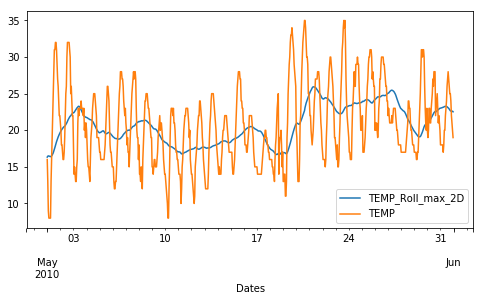

In [216]:
Beijing["TEMP_Roll_max_2D"]=Beijing["TEMP"].rolling('2D').mean()
Beijing.groupby(['year'])[['PM','PMlog','TEMP_Roll_max_2D']] \
.corr(method="pearson")['TEMP_Roll_max_2D'].loc[:,'PM']. \
to_frame('corr PM - TEMP (Pearson)')
_= Beijing["2010-05"][["TEMP_Roll_max_2D","TEMP"]].plot(figsize=(8,4))

,TEMP_1D,PM,PMlog
TEMP_1D,1.000000,-0.111965,0.001500
PM,-0.111965,1.000000,0.856523
PMlog,0.001500,0.856523,1.000000


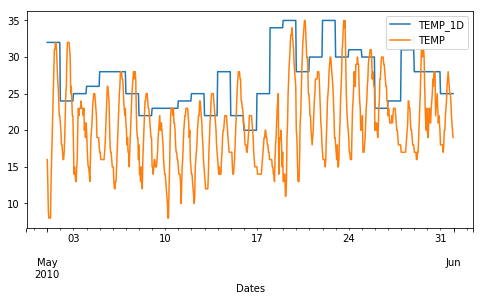

In [233]:
resample_and_shift(Beijing, "TEMP", "TEMP_1D",agg_func=np.max, shift_amount=-1)
Beijing[["TEMP_1D","PM","PMlog"]].corr(method="pearson")
_= Beijing["2010-05"][["TEMP_1D","TEMP"]].plot(figsize=(8,4))
#['TEMP_1D'].loc[:,'PM']. \
# to_frame('corr PM - TEMP (Pearson)')

## DEWP
Dewpoint in <sup>o</sup>C
- no aggrgation method was able to improve correlation

,count,mean,std,min,25%,50%,75%,max
DEWP,52579.0,2.074554,14.222059,-40.0,-10.0,2.0,15.0,28.0


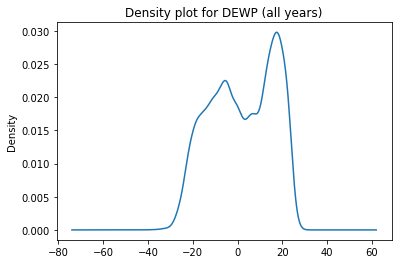

In [251]:
Beijing['DEWP'].describe().to_frame().T
_= Beijing['DEWP'].plot(kind="kde")
_= plt.title("Density plot for DEWP (all years)")

In [237]:
var_to_compute_corr=['PM','PMlog','DEWP']
compute_corr(Beijing.groupby("year"), ['PM','PMlog','DEWP'])

PM     PMlog      DEWP
year                                    
2010 PM     1.000000  0.867968  0.284323
     PMlog  0.867968  1.000000  0.397552
     DEWP   0.284323  0.397552  1.000000
2011 PM     1.000000  0.875967  0.272043
     PMlog  0.875967  1.000000  0.396754
     DEWP   0.272043  0.396754  1.000000
2012 PM     1.000000  0.867943  0.171897
     PMlog  0.867943  1.000000  0.283035
     DEWP   0.171897  0.283035  1.000000
2013 PM     1.000000  0.854303  0.074071
     PMlog  0.854303  1.000000  0.273764
     DEWP   0.074071  0.273764  1.000000
2014 PM     1.000000  0.851471  0.067773
     PMlog  0.851471  1.000000  0.219624
     DEWP   0.067773  0.219624  1.000000
2015 PM     1.000000  0.835428 -0.057271
     PMlog  0.835428  1.000000  0.080949
     DEWP  -0.057271  0.080949  1.000000

,PM,PMlog,HUMI,DEWP_Roll_median_D
PM,1.000000,0.856523,0.418533,0.051841
PMlog,0.856523,1.000000,0.486946,0.151231
HUMI,0.418533,0.486946,1.000000,0.509151
DEWP_Roll_median_D,0.051841,0.151231,0.509151,1.000000


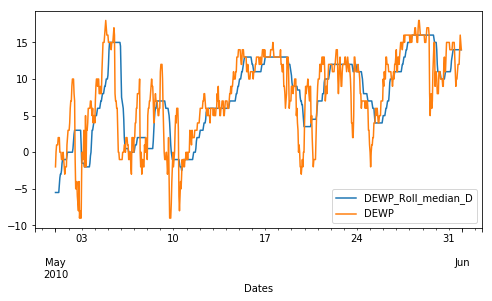

In [243]:
Beijing["DEWP_Roll_median_D"]=rolling_agg(Beijing,"DEWP",'D', agg_func=np.median)
_= Beijing["2010-05"][["DEWP_Roll_median_D","DEWP"]].plot(figsize=(8,4))
compute_corr(Beijing, ['PM','PMlog','HUMI','DEWP_Roll_median_D'])

,PM,PMlog,DEWP,DEWP_1D
PM,1.000000,0.856523,0.131236,0.021880
PMlog,0.856523,1.000000,0.265653,0.152871
DEWP,0.131236,0.265653,1.000000,0.929022
DEWP_1D,0.021880,0.152871,0.929022,1.000000


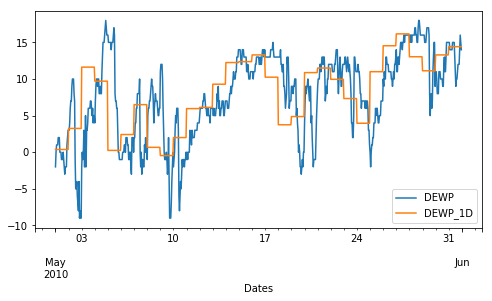

In [249]:
resample_and_shift(Beijing, "DEWP", "DEWP_1D",agg_func=np.mean, shift_amount=-1)
Beijing[["PM","PMlog","DEWP", "DEWP_1D"]].corr(method="pearson")
_= Beijing["2010-05"][["DEWP", "DEWP_1D"]].plot(figsize=(8,4))

## HUMI 
Humidity in %
- no aggragtion method was able to improve correlation results

,count,mean,std,min,25%,50%,75%,max
HUMI,52245.0,54.602421,25.991338,2.0,31.0,55.0,78.0,100.0


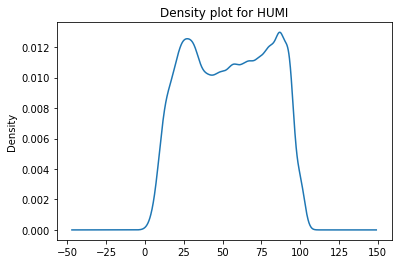

In [252]:
Beijing['HUMI'].describe().to_frame().T
_= Beijing['HUMI'].plot(kind="kde")

_= plt.title("Density plot for HUMI")

In [253]:
var_to_compute_corr=['PM','PMlog','HUMI']
compute_corr(Beijing.groupby("year"), ['PM','PMlog','HUMI'])

PM     PMlog      HUMI
year                                    
2010 PM     1.000000  0.867968  0.459430
     PMlog  0.867968  1.000000  0.529551
     HUMI   0.459430  0.529551  1.000000
2011 PM     1.000000  0.875967  0.485754
     PMlog  0.875967  1.000000  0.553365
     HUMI   0.485754  0.553365  1.000000
2012 PM     1.000000  0.867943  0.440284
     PMlog  0.867943  1.000000  0.497539
     HUMI   0.440284  0.497539  1.000000
2013 PM     1.000000  0.854303  0.445037
     PMlog  0.854303  1.000000  0.559461
     HUMI   0.445037  0.559461  1.000000
2014 PM     1.000000  0.851471  0.378970
     PMlog  0.851471  1.000000  0.465074
     HUMI   0.378970  0.465074  1.000000
2015 PM     1.000000  0.835428  0.337975
     PMlog  0.835428  1.000000  0.370541
     HUMI   0.337975  0.370541  1.000000

,PM,PMlog,HUMI,HUMI_Roll_median_D
PM,1.000000,0.856523,0.418533,0.322846
PMlog,0.856523,1.000000,0.486946,0.332630
HUMI,0.418533,0.486946,1.000000,0.714616
HUMI_Roll_median_D,0.322846,0.332630,0.714616,1.000000


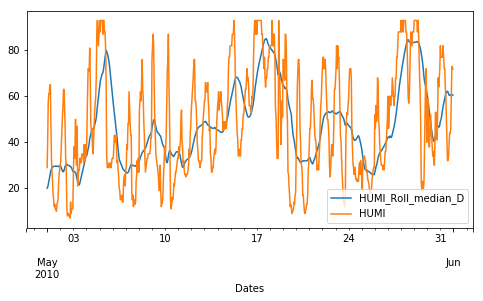

In [265]:
Beijing["HUMI_Roll_median_D"]=rolling_agg(Beijing,"HUMI",'D', agg_func=np.mean)
_= Beijing["2010-05"][["HUMI_Roll_median_D","HUMI"]].plot(figsize=(8,4))
compute_corr(Beijing, ['PM','PMlog','HUMI','HUMI_Roll_median_D'])

## PRES
pressure  in hPa

In [297]:
def analyze_var(df, str_var_name, str_title_kde_plot,str_var_name_agg, list_output_var=['PM','PMlog']):
   
    sts_df=df[str_var_name].describe().to_frame().T
    
    corr_vars=compute_corr(df,list_output_var.extend([str_var_name]))

    df[str_var_name_agg]= rolling_agg(df,str_var_name,"2D",np.mean)
    compute_corr(df, list_output_var.extend([str_var_name_agg]))
    
    # show charts
    _ = df[str_var_name].plot(kind="kde")
    
    _= plt.title(str_title_kde_plot)
    
    _= Beijing["2010-05"][[ str_var_name,str_var_name_agg,str_var_name]].plot(figsize=(8,4))

    return  sts_df, corrvars

In [298]:
analyze_var(Beijing, "PRES","Density plot for PRES (all years)","PRES_roll_mean_1D")

ValueError: cannot label index with a null key

In [306]:
l=['PM','PMlog']
l.extend(['HUMI_Roll_1D'])
print(*l) 

PM PMlog HUMI_Roll_1D


,count,mean,std,min,25%,50%,75%,max
PRES,52245.0,1016.465442,10.29507,991.0,1008.0,1016.0,1025.0,1046.0


PM PMlog PRES


,PM,PMlog,PRES
PM,1.000000,0.856523,-0.016833
PMlog,0.856523,1.000000,-0.123901
PRES,-0.016833,-0.123901,1.000000


['PM', 'PMlog', 'PRES', 'PRES_Roll_1D_Mean']


,PM,PMlog,PRES,PRES_Roll_1D_Mean
PM,1.000000,0.856523,-0.016833,0.104119
PMlog,0.856523,1.000000,-0.123901,0.019749
PRES,-0.016833,-0.123901,1.000000,0.918237
PRES_Roll_1D_Mean,0.104119,0.019749,0.918237,1.000000


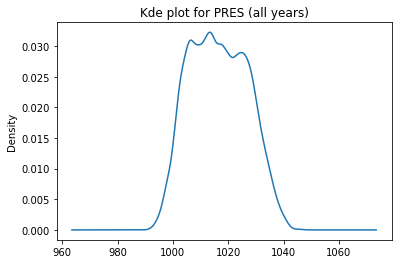

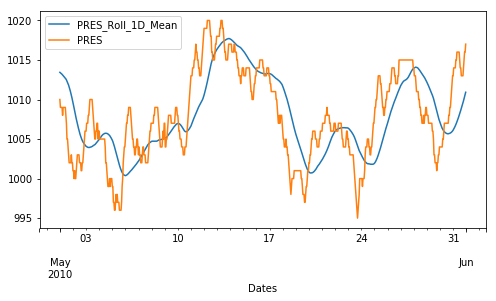

In [315]:
df=Beijing
str_var_name="PRES"
list_output_var=['PM','PMlog']
str_var_name_agg="PRES_Roll_1D_Mean"
str_title_kde_plot="Kde plot for {} (all years)".format(str_var_name)

sts_df=df[str_var_name].describe().to_frame().T

sts_df

list_output_var.extend([str_var_name])
print(*list_output_var)
                       
corr_vars=compute_corr(df,list_output_var)
corr_vars

df[str_var_name_agg]= rolling_agg(df,str_var_name,"2D",np.mean)

list_output_var.extend([str_var_name_agg])
print(list_output_var)
compute_corr(df,list_output_var)
    
# show charts
_ = df[str_var_name].plot(kind="kde")
 
_= plt.title(str_title_kde_plot)
    
_= df["2010-05"][[ str_var_name_agg,str_var_name]].plot(figsize=(8,4))

,PM,PMlog,PRES
PM,1.000000,0.856523,-0.016833
PMlog,0.856523,1.000000,-0.123901
PRES,-0.016833,-0.123901,1.000000


,PM,PMlog,PRES,PRES_roll_mean_1D
PM,1.000000,0.856523,-0.016833,0.104119
PMlog,0.856523,1.000000,-0.123901,0.019749
PRES,-0.016833,-0.123901,1.000000,0.918237
PRES_roll_mean_1D,0.104119,0.019749,0.918237,1.000000


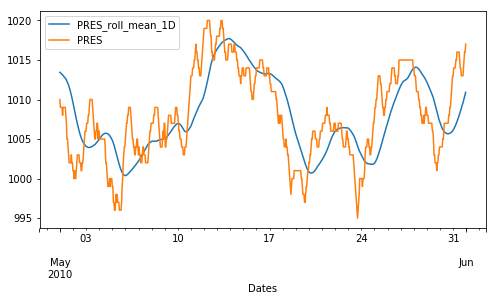

In [272]:
compute_corr(Beijing,["PM","PMlog","PRES"])

Beijing['PRES_roll_mean_1D']= rolling_agg(Beijing,"PRES","2D",np.mean)
compute_corr(Beijing,["PM","PMlog","PRES","PRES_roll_mean_1D"])
_= Beijing["2010-05"][["PRES_roll_mean_1D","PRES"]].plot(figsize=(8,4))

In [ ]:
#bins = pd.IntervalIndex.from_tuples([(-1, 1), (2,5),(6, 20), (21, 60)])

#Beijing.loc[Beijing['Iprec'] >300 ,'Iprec'] = np.nan
#pd.cut(Beijing['Iprec'],bins).value_counts()

#bins = pd.IntervalIndex.from_tuples([(-1, 1), (2,5),(6, 20), (21, 40), (41,50),(51,70)])
#df_Iprec = pd.cut(Beijing["Iprec"],bins).to_frame()
#df_Iprec.rename(columns={'Iprec':'bucket'}, inplace=True)
#df_Iprec.bucket.cat.rename_categories([ "very_low","low","normal", "medium", "high", "very_high"],inplace=True)
#df_Iprec["Iprec"]=Beijing.Iprec
#df_Iprec.sample(n=10)
#df_Iprec[['bucket','Iprec']].groupby('bucket').sum().plot(kind='bar');

### Correlation matrix plot

In [ ]:
Beijing.columns

In [ ]:
Beijing["Iws"].plot(kind="kde");
Beijing['daily_mean_Iws']= Beijing['Iws'].rolling('D').mean()
Beijing['daily_mean_Iws_log']=np.log10(1+Beijing['daily_mean_Iws'].values)
Beijing[['PMlog','daily_mean_Iws_log','Iws','daily_mean_Iws']].corr(method="pearson")
Beijing[['PMlog','daily_mean_Iws_log','Iws','daily_mean_Iws']].corr(method="spearman")

In [ ]:
Beijing["TEMP"].describe();
Beijing['daily_mean_TEMP']= Beijing['TEMP'].rolling('D').quantile(0.5).shift(24)
#Beijing['daily_mean_TEMP_log']=np.log10(1+Beijing['daily_mean_TEMP'].values)
Beijing[['PMlog','TEMP','daily_mean_TEMP']].corr(method="pearson")
Beijing[['PMlog','TEMP','daily_mean_TEMP']].corr(method="spearman")

In [ ]:
Beijing['TEMP'].rolling('D').apply("mean")

### Add time features

In [ ]:
Beijing["week_day_name"]=Beijing.index.weekday_name
#Beijing["week_day"]=Beijing["week_day"].astype('category')
_=sns.boxplot(data=Beijing, x="week_day_name",y="PM")
plt.xticks(rotation=90);

In [ ]:
Beijing.loc["2010-01-03 8:00:00":"2010-01-03 15:00:00"].T

In [ ]:
var_list=['PMlog', 'DEWP', 'HUMI',
       'PRES', 'TEMP', 'cbwd', 'Iws', 'Iprec', 'daily_mean_Iprec','daily_mean_Iws_log',
       'daily_mean_Iprec_log']

draw_corr_matrix()

In [ ]:
#Beijing.iloc[:,np.r_[0,5:Beijing.shape[1]]].dropna()

###  Transform continout variable into bucket/bins categorical

In [ ]:
Beijing.loc[Beijing['precipitation'] >300 ,'precipitation'] = np.nan
Beijing.precipitation.describe()
#Beijing["precipitation"].plot(kind="kde");
bins_prec = pd.IntervalIndex.from_tuples([(-1, 1), (2,5),(6, 20), (21, 60)])
df_precipitation = pd.cut(Beijing.precipitation,bins_prec).to_frame()
df_precipitation.rename(columns={'precipitation':'bucket'}, inplace=True)
df_precipitation.bucket.cat.rename_categories([ "low", "medium", "high", "very_high"],inplace=True)
df_precipitation["precipitation"]=Beijing.precipitation
df_precipitation.sample(n=10)

In [ ]:
df_precipitation[['bucket','precipitation']].groupby('bucket').sum().plot(kind='bar');

In [ ]:
#df_dummies_precipitation2 = pd.get_dummies(df_precipitation2['bucket'])
#df_dummies_precipitation2.head()
#del df_dummies[df_dummies.columns[-1]]
#df_new = pd.concat([df, df_dummies], axis=1)
#del df_new['color_head']
df_PM_precipitation2=pd.concat([ Beijing['PMlog'], df_precipitation2], axis=1)# df_dummies_precipitation2], axis=1)
df_PM_precipitation2.head()

#sns.catplot(y="PMlog", hue="bucket", kind="bar",x="bucket",
#            data=df_PM_precipitation2);
df_PM_precipitation2.plot.hist(by="bucket")

In [ ]:
df_PM_precipitation2.corr()

In [ ]:
Beijing.precipitation.head()

In [ ]:
Beijing.loc[:,["PMlog","IwsLog"]].dropna().head()

In [ ]:
variable_list=['PMlog', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'cbwd', 'IwsLog','Iws']
#sns.pairplot(Beijing[Beijing["year"]==2010].loc[:,variable_list], dropna=True, kind="reg");

xy=Beijing.loc[:,["PMlog","IwsLog"]].dropna()

from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2
#sns.jointplot(Beijing["PMlog"].values, Beijing["IwsLog"].values, kind="reg", stat_func=r2)
r2(xy["PMlog"].values, xy["IwsLog"].values)